In [3]:
%matplotlib inline
from fastai.basics import *
import typing

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [6]:
[e for e in dir(Config()) if "__" not in e]

['DEFAULT_CONFIG',
 'DEFAULT_CONFIG_LOCATION',
 'DEFAULT_CONFIG_PATH',
 'create',
 'data_archive_path',
 'data_path',
 'get',
 'get_key',
 'get_path',
 'model_path']

In [7]:
doc(Config)

In [10]:
path = Config().data_path()/'mnist'

In [11]:
path.ls()

[PosixPath('/Users/lindsayedwards/.fastai/data/mnist/.DS_Store'),
 PosixPath('/Users/lindsayedwards/.fastai/data/mnist/mnist.pkl.gz')]

In [20]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [21]:
# the images are imported as a vector, so need reshaping to be viewed
def show_image(x):
    plt.imshow(x.reshape((28,28)), cmap="gray")

In [22]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n, c = x_train.shape
print("Number of training examples: {}\nNumber of features: {}".format(n, c))

Number of training examples: 50000
Number of features: 784


In [23]:
# TensorDataset is a class in the pytorch library
# doc(TensorDataset)

In [24]:
# this has to be the lightest way of creating a DataBunch
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [29]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [30]:
a = torch.tensor([5., 4., 3., 2., 1.])

In [48]:
dropout_mask = np.random.binomial(n=1, p=.5, size=(764))

In [50]:
np.repeat(dropout_mask, 5)

array([0, 0, 0, 0, ..., 1, 1, 1, 1])

In [43]:
a * 5

tensor([25., 20., 15., 10.,  5.])

In [41]:
torch.cat([a,a,a]).reshape()

tensor([5., 4., 3., 2., 1., 5., 4., 3., 2., 1., 5., 4., 3., 2., 1.])

Edited by me (LME) to add dropout manually.  
nn.Linear is simply matmul.  
The source code is here: https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear  
Also using the lovely `typing` library to allow type annotation.  

In [73]:
class MnistLogistic(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
#         self.dropout = nn.Linear(784, 784, bias=False) # dropout layer
        self.fully_con = nn.Linear(784, 10, bias=True)
        
    def dropout(self, X: torch.tensor, p: float) -> torch.tensor:
        """Take a tensor (X) and replace values at random with 0 with probability p (by
        taking the Hadamard product with a matrix of ones and zeros).  
        The mask should be the same for every element of the batch.  
        Parameters
        ----------
        X : torch.tensor
        p : float
        """
        dropout_mask = np.random.binomial(n=1, p=1-p, size=(X.size()[1])) # one mask for all examples
        dropout_mask = np.repeat(dropout_mask, X.size()[0])
        return (X * torch.FloatTensor(dropout_mask).reshape(X.size()))

    def forward(self, xb): 
        xb = self.dropout(xb, self.p)
        xb = self.fully_con(xb)
        return (xb)

In [101]:
model = MnistLogistic(p = 0)
model

MnistLogistic(
  (fully_con): Linear(in_features=784, out_features=10, bias=True)
)

In [102]:
# pull out a single layer
model.fully_con

Linear(in_features=784, out_features=10, bias=True)

In [103]:
# view the shape of the output
model(x).shape

torch.Size([64, 10])

In [104]:
# look at the shape of the parameter matrices
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [105]:
lr=2e-2
loss_func = nn.CrossEntropyLoss()

In [106]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [107]:
losses = [update(x,y,lr) for x,y in data.train_dl]

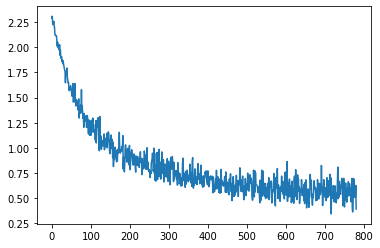

In [108]:
plt.plot(losses);

In [109]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [110]:
model = Mnist_NN()

In [111]:
losses = [update(x,y,lr) for x,y in data.train_dl]

In [112]:
plt.plot(losses);

In [113]:
model = Mnist_NN()

In [114]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [115]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

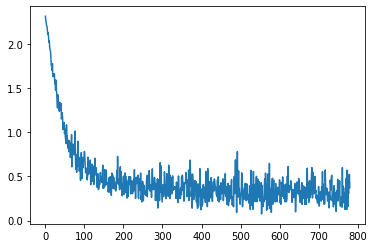

In [116]:
plt.plot(losses);

In [ ]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [ ]:
%debug

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.recorder.plot_losses()

## fin